# Synthetic data test to analyse errors in center location

This notebook generates the results and figures for section "Robustness against errors in the centre location".

----

### Note
This is an [IPython notebook](http://ipython.org/notebook.html), a document that incorporates text, results, figures, and the [Python](http://www.python.org/) source code to produce them. If you are viewing this from the URL http://nbviewer.ipython.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install the software required. See the instructions at https://github.com/pinga-lab/Total-magnetization-of-spherical-bodies.

These numerical tests use the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://fatiando.org/).

----

## Setup

First, we'll import the required libraries.

In [1]:
%matplotlib inline
import numpy
from fatiando import mesher, gridder, gravmag
from fatiando.gravmag import sphere, prism, polyprism, fourier
from fatiando.gravmag.euler import Classic, ExpandingWindow
from fatiando.utils import ang2vec, contaminate
from fatiando.vis import mpl, myv
from fatiando.gravmag.magdir import DipoleMagDir
import fatiando

In [2]:
print('Using Fatiando a Terra version {}'.format(fatiando.__version__))

Using Fatiando a Terra version 0.3


In [3]:
mpl.rcParams['font.size'] = 14

In [5]:
# Make noise-corrupted synthetic data
inc, dec = -9.5, -13.0 # inclination and declination of the Geomagnetic Field
incs, decs = -40.0, -13.0 # inclination and declination of the body
model = mesher.Sphere(5000, 5000, 1000, 1000, 
                       {'magnetization': ang2vec(8.0, incs, decs)})
area = [0, 10000, 0, 10000]
x, y, z = gridder.regular(area, (51,51), z=-150)
tf = contaminate(gravmag.sphere.tf(x, y, z, [model], inc, dec), 2.0)

In [6]:
# Construct the perturbed centers
dc = 100.0 # absolut value of the perturbation
ndc = 10
centers_x = numpy.array([[(model.x - ndc*dc + i*dc), model.y, model.z]
                          for i in range(2*ndc + 1)])
centers_y = numpy.array([[model.x, (model.y - ndc*dc + i*dc), model.z]
                          for i in range(2*ndc + 1)])
centers_z = numpy.array([[model.x, model.y, (model.z - ndc*dc + i*dc)]
                          for i in range(2*ndc + 1)])

In [8]:
# Lists used to store the estimates
estimates_x_L2 = []
estimates_y_L2 = []
estimates_z_L2 = []
estimates_x_L1 = []
estimates_y_L1 = []
estimates_z_L1 = []

Q = 30

# Estimate the magnetization with the perturbed centers
for i, c in enumerate(centers_x):
    solver = DipoleMagDir(x, y, z, tf, inc, dec, [c]).fit()
    estimates_x_L2.append(solver.estimate_[0])
    for j in range(Q):
        w = numpy.abs(solver.residuals())
        w[w < 10**(-10)] = 10**-10
        w = 1/w
        solver.set_weights(w)
        solver.fit()
    estimates_x_L1.append(solver.estimate_[0])
    
for i, c in enumerate(centers_y):
    solver = DipoleMagDir(x, y, z, tf, inc, dec, [c]).fit()
    estimates_y_L2.append(solver.estimate_[0])
    for j in range(Q):
        w = numpy.abs(solver.residuals())
        w[w < 10**(-10)] = 10**-10
        w = 1/w
        solver.set_weights(w)
        solver.fit()
    estimates_y_L1.append(solver.estimate_[0])
    
for i, c in enumerate(centers_z):
    solver = DipoleMagDir(x, y, z, tf, inc, dec, [c]).fit()
    estimates_z_L2.append(solver.estimate_[0])
    for j in range(Q):
        w = numpy.abs(solver.residuals())
        w[w < 10**(-10)] = 10**-10
        w = 1/w
        solver.set_weights(w)
        solver.fit()
    estimates_z_L1.append(solver.estimate_[0])
    
estimates_x_L2 = numpy.array(estimates_x_L2)
estimates_y_L2 = numpy.array(estimates_y_L2)
estimates_z_L2 = numpy.array(estimates_z_L2)
estimates_x_L1 = numpy.array(estimates_x_L1)
estimates_y_L1 = numpy.array(estimates_y_L1)
estimates_z_L1 = numpy.array(estimates_z_L1)

Generate the figure for the paper.

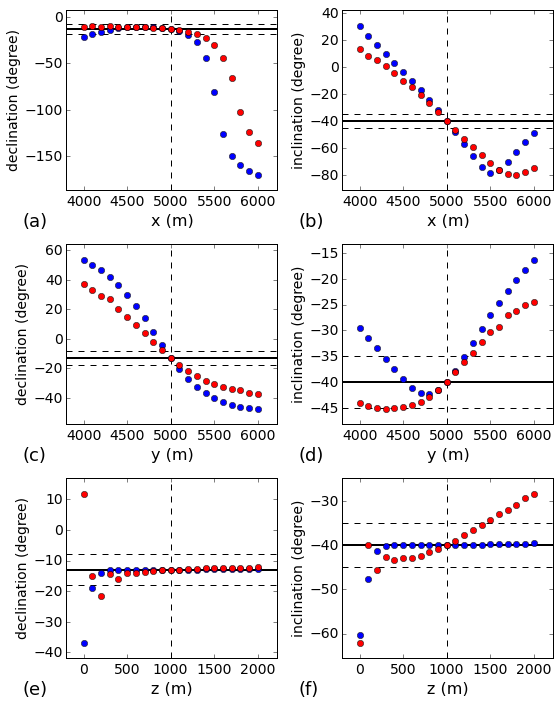

In [10]:
mpl.close('all')
mpl.figure(figsize = (8, 10), tight_layout = True)

tol = 0.1
index = 0.2
marker_size = 6

#Plot the results along the x axis
smin = numpy.min(centers_x[:,0])
smax = numpy.max(centers_x[:,0])
smin = smin - tol*(smax - smin)
smax = smax + tol*(smax - smin)

#Plot the estimated declinations
tmin = numpy.min([estimates_x_L2[:,2], estimates_x_L1[:,2]])
tmax = numpy.max([estimates_x_L2[:,2], estimates_x_L1[:,2]])
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)
mpl.subplot(3, 2, 1)
mpl.paths([[model.x, tmin]], [[model.x, tmax]], style='--k', linewidth=1)
mpl.paths([[smin, decs - 5.0]], [[smax, decs - 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, decs + 5.0]], [[smax, decs + 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, decs]], [[smax, decs]], style='-k', linewidth=2)
mpl.plot(centers_x[:,0], estimates_x_L2[:,2], 'ob', linewidth=3, markersize = marker_size)
mpl.plot(centers_x[:,0], estimates_x_L1[:,2], 'or', linewidth=3, markersize = marker_size)
mpl.xlabel("x (m)", fontsize = 16)
mpl.ylabel("declination (degree)", fontsize = 14)
mpl.xlim(smin,smax)
mpl.ylim(tmin,tmax)
mpl.text(smin-index*(smax-smin), tmin-index*(tmax-tmin), '(a)', fontsize=18)

#Plot the estimated inclinations
mpl.subplot(3, 2, 2)
tmin = numpy.min([estimates_x_L2[:,1], estimates_x_L1[:,1]])
tmax = numpy.max([estimates_x_L2[:,1], estimates_x_L1[:,1]])
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)
mpl.paths([[model.x, tmin]], [[model.x, tmax]], style='--k', linewidth=1)
mpl.paths([[smin, incs - 5.0]], [[smax, incs - 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, incs + 5.0]], [[smax, incs + 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, incs]], [[smax, incs]], style='-k', linewidth=2)
mpl.plot(centers_x[:,0], estimates_x_L2[:,1], 'ob', linewidth=3, markersize = marker_size)
mpl.plot(centers_x[:,0], estimates_x_L1[:,1], 'or', linewidth=3, markersize = marker_size)
mpl.xlabel("x (m)", fontsize = 16)
mpl.ylabel("inclination (degree)", fontsize = 14)
mpl.xlim(smin,smax)
mpl.ylim(tmin,tmax)
mpl.text(smin-index*(smax-smin), tmin-index*(tmax-tmin), '(b)', fontsize=18)

#Plot the results along the y axis
smin = numpy.min(centers_y[:,1])
smax = numpy.max(centers_y[:,1])
smin = smin - tol*(smax - smin)
smax = smax + tol*(smax - smin)

#Plot the estimated declinations
tmin = numpy.min([estimates_y_L2[:,2], estimates_y_L1[:,2]])
tmax = numpy.max([estimates_y_L2[:,2], estimates_y_L1[:,2]])
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)
mpl.subplot(3, 2, 3)
mpl.paths([[model.y, tmin]], [[model.y, tmax]], style='--k', linewidth=1)
mpl.paths([[smin, decs - 5.0]], [[smax, decs - 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, decs + 5.0]], [[smax, decs + 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, decs]], [[smax, decs]], style='-k', linewidth=2)
mpl.plot(centers_y[:,1], estimates_y_L2[:,2], 'ob', linewidth=3, markersize = marker_size)
mpl.plot(centers_y[:,1], estimates_y_L1[:,2], 'or', linewidth=3, markersize = marker_size)
mpl.xlabel("y (m)", fontsize = 16)
mpl.ylabel("declination (degree)", fontsize = 14)
mpl.xlim(smin,smax)
mpl.ylim(tmin,tmax)
mpl.text(smin-index*(smax-smin), tmin-index*(tmax-tmin), '(c)', fontsize=18)

#Plot the estimated inclinations
mpl.subplot(3, 2, 4)
tmin = numpy.min([estimates_y_L2[:,1], estimates_y_L1[:,1]])
tmax = numpy.max([estimates_y_L2[:,1], estimates_y_L1[:,1]])
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)
mpl.paths([[model.y, tmin]], [[model.y, tmax]], style='--k', linewidth=1)
mpl.paths([[smin, incs - 5.0]], [[smax, incs - 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, incs + 5.0]], [[smax, incs + 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, incs]], [[smax, incs]], style='-k', linewidth=2)
mpl.plot(centers_y[:,1], estimates_y_L2[:,1], 'ob', linewidth=3, markersize = marker_size)
mpl.plot(centers_y[:,1], estimates_y_L1[:,1], 'or', linewidth=3, markersize = marker_size)
mpl.xlabel("y (m)", fontsize = 16)
mpl.ylabel("inclination (degree)", fontsize = 14)
mpl.xlim(smin,smax)
mpl.ylim(tmin,tmax)
mpl.text(smin-index*(smax-smin), tmin-index*(tmax-tmin), '(d)', fontsize=18)

#Plot the results along the z axis
smin = numpy.min(centers_z[:,2])
smax = numpy.max(centers_z[:,2])
smin = smin - tol*(smax - smin)
smax = smax + tol*(smax - smin)

#Plot the estimated declinations
tmin = numpy.min([estimates_z_L2[:,2], estimates_z_L1[:,2]])
tmax = numpy.max([estimates_z_L2[:,2], estimates_z_L1[:,2]])
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)
mpl.subplot(3, 2, 5)
mpl.paths([[model.z, tmin]], [[model.z, tmax]], style='--k', linewidth=1)
mpl.paths([[smin, decs - 5.0]], [[smax, decs - 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, decs + 5.0]], [[smax, decs + 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, decs]], [[smax, decs]], style='-k', linewidth=2)
mpl.plot(centers_z[:,2], estimates_z_L2[:,2], 'ob', linewidth=3, markersize = marker_size)
mpl.plot(centers_z[:,2], estimates_z_L1[:,2], 'or', linewidth=3, markersize = marker_size)
mpl.xlabel("z (m)", fontsize = 16)
mpl.ylabel("declination (degree)", fontsize = 14)
mpl.xlim(smin,smax)
mpl.ylim(tmin,tmax)
mpl.text(smin-index*(smax-smin), tmin-index*(tmax-tmin), '(e)', fontsize=18)

#Plot the estimated inclinations
mpl.subplot(3, 2, 6)
tmin = numpy.min([estimates_z_L2[:,1], estimates_z_L1[:,1]])
tmax = numpy.max([estimates_z_L2[:,1], estimates_z_L1[:,1]])
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)
mpl.paths([[model.z, tmin]], [[model.z, tmax]], style='--k', linewidth=1)
mpl.paths([[smin, incs - 5.0]], [[smax, incs - 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, incs + 5.0]], [[smax, incs + 5.0]], style='--k', linewidth=1)
mpl.paths([[smin, incs]], [[smax, incs]], style='-k', linewidth=2)
mpl.plot(centers_z[:,2], estimates_z_L2[:,1], 'ob', linewidth=3, markersize = marker_size)
mpl.plot(centers_z[:,2], estimates_z_L1[:,1], 'or', linewidth=3, markersize = marker_size)
mpl.xlabel("z (m)", fontsize = 16)
mpl.ylabel("inclination (degree)", fontsize = 14)
mpl.xlim(smin,smax)
mpl.ylim(tmin,tmax)
mpl.text(smin-index*(smax-smin), tmin-index*(tmax-tmin), '(f)', fontsize=18)
mpl.show()